This project is written to create a complete system that detects faces from a camera, tracks emotion changes, saves the image when an emotion change occurs, and identifies the emotion using a machine learning model trained on the FER2013 dataset.

# First version - as is. Simply CNN model.

____

### Step 1: Intsall requrements libraries, modelues and etc.

In [2]:
import numpy as np
import cv2
import os
import pandas as pd
import glob


from matplotlib import pyplot

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report

from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, BatchNormalization, Dropout, Input
from keras.optimizers import Adam
from keras.utils import to_categorical
from keras.callbacks import EarlyStopping, ModelCheckpoint, LearningRateScheduler, ReduceLROnPlateau
from keras.models import load_model

import tensorflow as tf

In [2]:
os.environ['TF_FORCE_GPU_ALLOW_GROWTH'] = 'true'

In [3]:
print("TensorFlow версии:", tf.__version__)

TensorFlow версии: 2.16.1


#### More detailed data analysis in the notepad: data_analysis.ipnb

### Step 2: Load and Preprocess the FER2013 Dataset

In [4]:
# the link for loading data set https://www.kaggle.com/datasets/ashishpatel26/facial-expression-recognitionferchallenge/data

In [3]:
df = pd.read_csv('../py_files/data/fer2013.csv')
print(df.shape)
df.head()

(35887, 3)


,emotion,pixels,Usage
0,0,70 80 82 72 58 58 60 63 54 58 60 48 89 115 121...,Training
1,0,151 150 147 155 148 133 111 140 170 174 182 15...,Training
2,2,231 212 156 164 174 138 161 173 182 200 106 38...,Training
3,4,24 32 36 30 32 23 19 20 30 41 21 22 32 34 21 1...,Training
4,6,4 0 0 0 0 0 0 0 0 0 0 0 3 15 23 28 48 50 58 84...,Training


In [4]:
emotion_label_to_text = {0:'anger', 1:'disgust', 2:'fear', 3:'happiness', 4: 'sadness', 5: 'surprise', 6: 'neutral'}

In [5]:
df.emotion.map(emotion_label_to_text).value_counts()

emotion
happiness    8989
neutral      6198
sadness      6077
fear         5121
anger        4953
surprise     4002
disgust       547
Name: count, dtype: int64

***Conclusion 1***
> We see a disbalance of classes, but we will try to take this into account using weights (for example) in another version of the code; in this example, we will show the result as is, so that we have something to compare with.

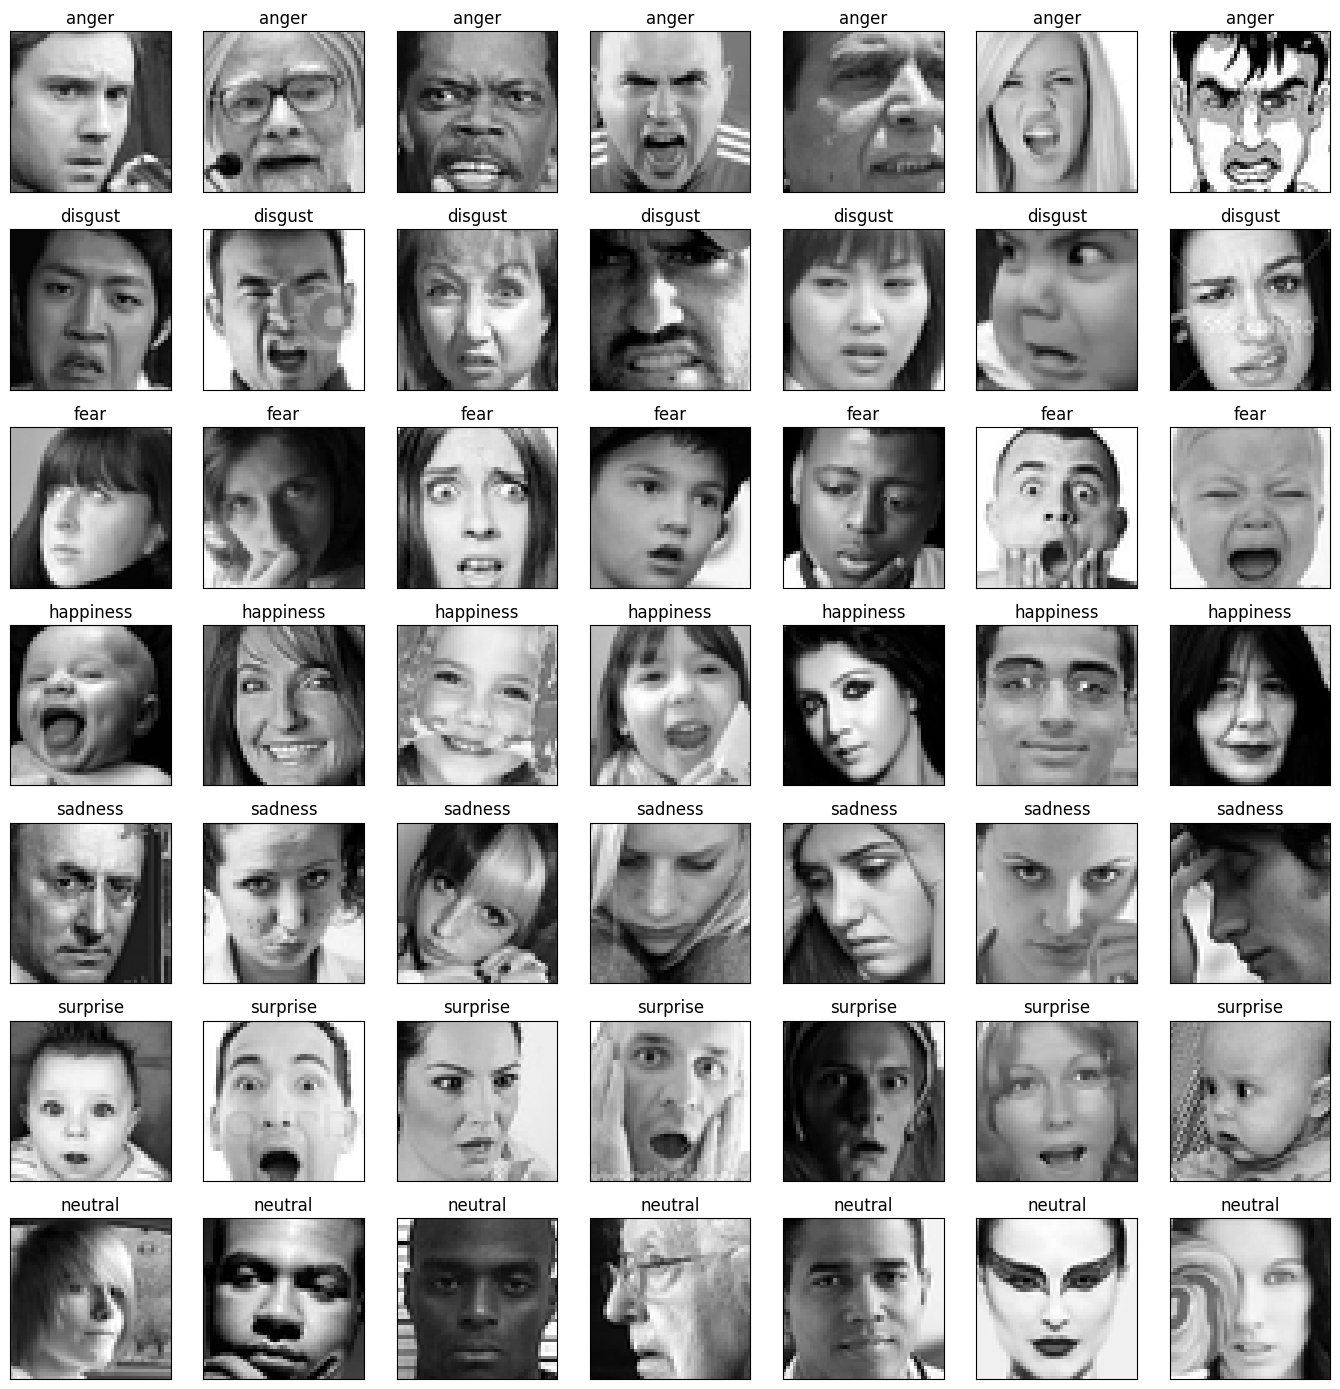

In [10]:
fig = pyplot.figure(1, (14, 14))

k = 0
for label in sorted(df.emotion.unique()):
    for j in range(7):
        px = df[df.emotion == label].pixels.iloc[k]
        px = np.array(px.split(' ')).reshape(48, 48).astype('float32')

        k += 1
        ax = pyplot.subplot(7, 7, k)
        ax.imshow(px, cmap = 'gray')
        ax.set_xticks([])
        ax.set_yticks([])
        ax.set_title(emotion_label_to_text[label])
        pyplot.tight_layout()

In [11]:
df.shape

(35887, 3)

In [12]:
# Convert the encoded labels to one-hot encoded format
le = LabelEncoder()
img_labels = le.fit_transform(df.emotion)
img_labels = to_categorical(img_labels)
img_labels.shape

(35887, 7)

In [13]:
img_labels[:5]

array([[1., 0., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1., 0., 0.],
       [0., 0., 0., 0., 0., 0., 1.]])

In [14]:
# Create a mapping from original class labels to their encoded values
le_name_mapping = dict(zip(le.classes_, le.transform(le.classes_)))
print(le_name_mapping)

{0: 0, 1: 1, 2: 2, 3: 3, 4: 4, 5: 5, 6: 6}


In [15]:
# Converting a DataFrame column containing image data into a 3D numpy array

# This lambda function takes a string representation of pixel values, splits it into a list of strings, 
# converts each string to a float, and then reshapes the list into a 48x48x1 numpy array.
img_array = df.pixels.apply(lambda x: np.array(x.split(' ')).reshape(48, 48, 1).astype('float32'))

# Stack the 2D arrays (images) into a single 3D array.
img_array = np.stack(img_array, axis=0)

# https://numpy.org/doc/1.13/reference/generated/numpy.dstack.html

In [16]:
img_array.shape

(35887, 48, 48, 1)

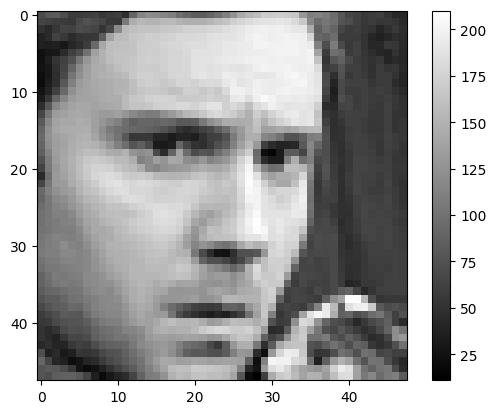

In [17]:
# Display, for example, the first image
image_to_display = img_array[0]

pyplot.imshow(image_to_display, cmap='gray')
pyplot.colorbar()
pyplot.show()

In [18]:
# Divide the sample into training and validation data
X_train, X_valid, y_train, y_valid = train_test_split(img_array, img_labels,
                                                    shuffle = True, stratify = img_labels,
                                                    test_size = 0.2, random_state = 42)

In [19]:
X_train.shape, X_valid.shape, y_train.shape, y_valid.shape

((28709, 48, 48, 1), (7178, 48, 48, 1), (28709, 7), (7178, 7))

In [20]:
img_width = X_train.shape[1]
img_height = X_train.shape[2]
img_depth = X_train.shape[3] 
num_classes = y_train.shape[1]

In [21]:
# Normalizing results, as neural networks are very sensitive to unnormalized data.
X_train = X_train / 255.
X_valid = X_valid / 255.

In [22]:
input_shape = (img_width, img_height, 1) 

### Step 3: Define and Train the Model
Define a CNN model for emotion detection and train it on the FER2013 dataset.

In [23]:
def create_cnn_model(input_shape = (48, 48, 1)):
    model = Sequential()
    model.add(Conv2D(32, (3, 3), activation='relu', padding = "same", input_shape=input_shape))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
    model.add(Dropout(0.1))

    model.add(Conv2D(64, (3, 3), activation='relu', padding = "same"))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
    model.add(Dropout(0.1))

    model.add(Conv2D(128, (3, 3), activation='relu', padding = "same"))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
    model.add(Dropout(0.1))

    model.add(Conv2D(512, (3, 3), activation='relu', padding = "same"))
    model.add(BatchNormalization())
    model.add(MaxPooling2D((2, 2), strides=(2,2)))
    model.add(Dropout(0.1))
    
    model.add(Flatten())
    model.add(Dense(256, activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.1))

    model.add(Dense(128, activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.1))

    model.add(Dense(64, activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.1))


    model.add(Dense(7, activation = 'softmax')) # 7 emotions
    return model


In [24]:
# Create the model
model = create_cnn_model(input_shape)

# Compile the model
model.compile(optimizer = 'adam', loss = 'categorical_crossentropy', metrics = ['accuracy','Precision','Recall'])

model.summary()


/home/alexander/anaconda3/lib/python3.11/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
2024-05-28 10:52:21.865202: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-05-28 10:52:21.866160: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/te

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 48, 48, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 48, 48, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 24, 24, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 24, 24, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 24, 24, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 24, 24, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 12, 12, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 12, 12, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 12, 12, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 12, 12, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 6, 6, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 6, 6, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 6, 6, 512)      │       590,336 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 6, 6, 512)      │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 3, 3, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 3, 3, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 4608)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │     1,179,904 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │             

 Total params: 1,909,255 (7.28 MB)

 Trainable params: 1,906,887 (7.27 MB)

 Non-trainable params: 2,368 (9.25 KB)

In [25]:
# Set up early stopping and model checkpointing
early_stopping = EarlyStopping(monitor = 'val_accuracy', min_delta = 0.00005, patience = 5, restore_best_weights = True)
lr_scheduler = ReduceLROnPlateau(monitor='val_accuracy', factor = 0.2, patience = 5, min_lr = 1e-7)
model_checkpoint = ModelCheckpoint('best_model.keras', monitor = 'val_loss', save_best_only = True, mode = 'min')

In [26]:
# Train the model
history = model.fit(X_train, 
                    y_train, 
                    epochs=50, 
                    batch_size=32, 
                    validation_data=(X_valid, y_valid), 
                    callbacks=[early_stopping, model_checkpoint, lr_scheduler])

Epoch 1/50


2024-05-28 10:52:22.697548: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 264582144 exceeds 10% of free system memory.
2024-05-28 10:52:22.849771: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 264582144 exceeds 10% of free system memory.
I0000 00:00:1716882746.496239   85005 service.cc:145] XLA service 0x7f6bc8001ff0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1716882746.496266   85005 service.cc:153]   StreamExecutor device (0): NVIDIA GeForce GTX 1650, Compute Capability 7.5
2024-05-28 10:52:26.592208: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-05-28 10:52:27.006440: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:465] Loaded cuDNN version 8902
2024-05-28 10:52:31.406927: W external/local_tsl/tsl/framework/bfc_allocator.cc:296] Allocator (GPU_0_

 17/898 ━━━━━━━━━━━━━━━━━━━━ 9s 11ms/step - Precision: 0.1816 - Recall: 0.0690 - accuracy: 0.1591 - loss: 2.6093 

I0000 00:00:1716882756.900463   85005 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


897/898 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - Precision: 0.3594 - Recall: 0.0559 - accuracy: 0.2562 - loss: 1.9542

2024-05-28 10:52:50.474124: W external/local_tsl/tsl/framework/bfc_allocator.cc:296] Allocator (GPU_0_bfc) ran out of memory trying to allocate 163.66MiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2024-05-28 10:52:50.474182: W external/local_tsl/tsl/framework/bfc_allocator.cc:296] Allocator (GPU_0_bfc) ran out of memory trying to allocate 301.28MiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2024-05-28 10:52:50.530672: W external/local_tsl/tsl/framework/bfc_allocator.cc:296] Allocator (GPU_0_bfc) ran out of memory trying to allocate 167.88MiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.


898/898 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - Precision: 0.3596 - Recall: 0.0560 - accuracy: 0.2563 - loss: 1.9540

I0000 00:00:1716882775.850126   85005 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'input_reduce_fusion', 8 bytes spill stores, 8 bytes spill loads



898/898 ━━━━━━━━━━━━━━━━━━━━ 35s 24ms/step - Precision: 0.3598 - Recall: 0.0560 - accuracy: 0.2564 - loss: 1.9537 - val_Precision: 0.5033 - val_Recall: 0.2037 - val_accuracy: 0.3435 - val_loss: 1.7326 - learning_rate: 0.0010
Epoch 2/50
898/898 ━━━━━━━━━━━━━━━━━━━━ 10s 11ms/step - Precision: 0.6975 - Recall: 0.2236 - accuracy: 0.4483 - loss: 1.4329 - val_Precision: 0.6679 - val_Recall: 0.2743 - val_accuracy: 0.4575 - val_loss: 1.4060 - learning_rate: 0.0010
Epoch 3/50
898/898 ━━━━━━━━━━━━━━━━━━━━ 9s 10ms/step - Precision: 0.7280 - Recall: 0.2992 - accuracy: 0.5157 - loss: 1.2734 - val_Precision: 0.6624 - val_Recall: 0.3130 - val_accuracy: 0.4815 - val_loss: 1.3367 - learning_rate: 0.0010
Epoch 4/50
898/898 ━━━━━━━━━━━━━━━━━━━━ 10s 11ms/step - Precision: 0.7322 - Recall: 0.3594 - accuracy: 0.5533 - loss: 1.1826 - val_Precision: 0.7321 - val_Recall: 0.3610 - val_accuracy: 0.5460 - val_loss: 1.1711 - learning_rate: 0.0010
Epoch 5/50
898/898 ━━━━━━━━━━━━━━━━━━━━ 9s 11ms/step - Precision: 0.

In [ ]:
# # Load the best model
# model = load_model('best_model.keras')

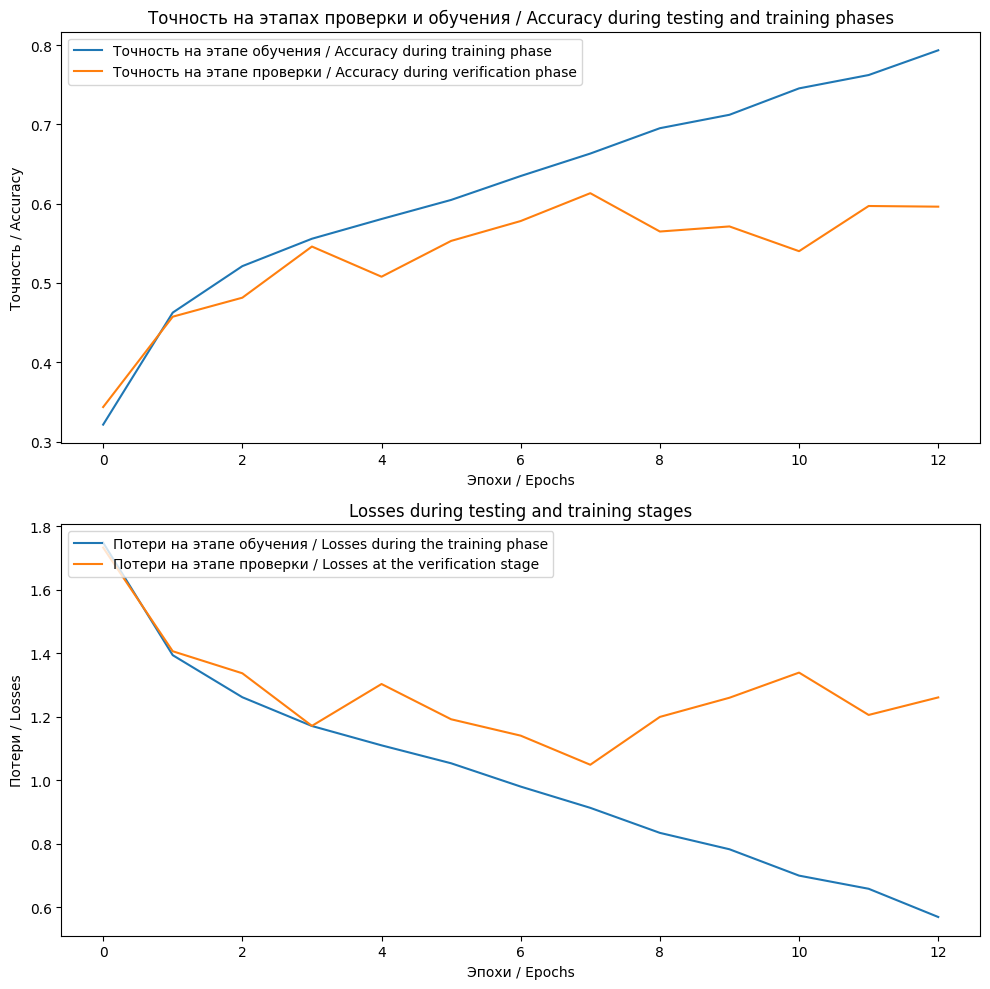

In [27]:

fig, axs = pyplot.subplots(2, 1, figsize=(10, 10))

# Accuracy / График точности
axs[0].plot(history.history['accuracy'], label='Точность на этапе обучения / Accuracy during training phase')
axs[0].plot(history.history['val_accuracy'], label='Точность на этапе проверки / Accuracy during verification phase')
axs[0].set_title('Точность на этапах проверки и обучения / Accuracy during testing and training phases')
axs[0].set_ylabel('Точность / Accuracy')
axs[0].set_xlabel('Эпохи / Epochs')
axs[0].legend(loc='upper left')

# Loss / График потерь
axs[1].plot(history.history['loss'], label='Потери на этапе обучения / Losses during the training phase')
axs[1].plot(history.history['val_loss'], label='Потери на этапе проверки / Losses at the verification stage')
axs[1].set_title('Losses during testing and training stages')
axs[1].set_ylabel('Потери / Losses')
axs[1].set_xlabel('Эпохи / Epochs')
axs[1].legend(loc='upper left')

# Отображаем графики
pyplot.tight_layout()  # Оптимизирует поля и расположение объектов
pyplot.show()


In [28]:
predictions = model.predict(X_valid)


225/225 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


In [29]:
# Convert probabilities to class labels
predicted_classes = np.argmax(predictions, axis = 1)


In [30]:
predicted_classes_one_hot = to_categorical(predicted_classes, num_classes = 7)

# Now, both predicted_classes_one_hot and y_valid are in the same format
report = classification_report(y_valid, predicted_classes_one_hot)
print(report)


              precision    recall  f1-score   support

           0       0.59      0.47      0.52       991
           1       0.76      0.44      0.56       109
           2       0.56      0.30      0.39      1024
           3       0.78      0.83      0.81      1798
           4       0.44      0.59      0.51      1216
           5       0.74      0.76      0.75       800
           6       0.53      0.60      0.57      1240

   micro avg       0.61      0.61      0.61      7178
   macro avg       0.63      0.57      0.59      7178
weighted avg       0.62      0.61      0.61      7178
 samples avg       0.61      0.61      0.61      7178



In [35]:
# # Load the best model
# model = load_model('best_model.keras')

### Step 4: Implement the Emotion Detection Function
Implement the detect_emotion function using the trained model.

In [37]:
def detect_emotion(image):
    image = cv2.resize(image, (48, 48))
    image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    image = np.expand_dims(image, axis=-1)
    image = np.expand_dims(image, axis=0)
    
    prediction = model.predict(image)
    emotion_index = np.argmax(prediction)
    
    emotion_labels = ['Anger', 'Disgust', 'Fear', 'Happy', 'Sad', 'Surprise', 'Neutral']
    emotion = emotion_labels[emotion_index]
    
    return emotion


### Step 5: Integrate Face Detection and Emotion Detection
Integrate the face detection code with the emotion detection fqunction. When an emotion change is detected, save the image, close the camera, and print the detected emotion.

In [32]:
face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')

device_name = "/dev/video0"
cap = cv2.VideoCapture(device_name, cv2.CAP_V4L2)

save_dir = "./face_images_asis/"
if not os.path.exists(save_dir):
    os.makedirs(save_dir)

last_emotion = None
emotion_images = []
frame_count = 0

while True:
    ret, frame = cap.read()
    gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    faces = face_cascade.detectMultiScale(gray, scaleFactor=1.1, minNeighbors=5, minSize=(30, 30))
    
    if len(faces) > 0:
        (x, y, w, h) = faces[0]
        face_image = frame[y:y+h, x:x+w]
        
        current_emotion = detect_emotion(face_image)
        
        if current_emotion != last_emotion:
            # Draw the emotion label on the face image
            cv2.putText(face_image, current_emotion, (10, 30), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 0, 255), 2)
            
            # Save the face image with the emotion label
            image_path = os.path.join(save_dir, f"face_{frame_count}.jpg")
            cv2.imwrite(image_path, face_image)

            # Add the emotion image to the list
            emotion_images.append(face_image)
            last_emotion = current_emotion
            frame_count += 1

    cv2.imshow('Video', frame)
    
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

cap.release()
cv2.destroyAllWindows()


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 833ms/step


2024-05-28 10:56:15.031492: W external/local_tsl/tsl/framework/bfc_allocator.cc:368] Garbage collection: deallocate free memory regions (i.e., allocations) so that we can re-allocate a larger region to avoid OOM due to memory fragmentation. If you see this message frequently, you are running near the threshold of the available device memory and re-allocation may incur great performance overhead. You may try smaller batch sizes to observe the performance impact. Set TF_ENABLE_GPU_GARBAGE_COLLECTION=false if you'd like to disable this feature.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step


QObject::moveToThread: Current thread (0x2c518dd0) is not the object's thread (0x2c530a20).
Cannot move to target thread (0x2c518dd0)

QObject::moveToThread: Current thread (0x2c518dd0) is not the object's thread (0x2c530a20).
Cannot move to target thread (0x2c518dd0)

QObject::moveToThread: Current thread (0x2c518dd0) is not the object's thread (0x2c530a20).
Cannot move to target thread (0x2c518dd0)

QObject::moveToThread: Current thread (0x2c518dd0) is not the object's thread (0x2c530a20).
Cannot move to target thread (0x2c518dd0)

QObject::moveToThread: Current thread (0x2c518dd0) is not the object's thread (0x2c530a20).
Cannot move to target thread (0x2c518dd0)

QObject::moveToThread: Current thread (0x2c518dd0) is not the object's thread (0x2c530a20).
Cannot move to target thread (0x2c518dd0)

QObject::moveToThread: Current thread (0x2c518dd0) is not the object's thread (0x2c530a20).
Cannot move to target thread (0x2c518dd0)

QObject::moveToThread: Current thread (0x2c518dd0) is n

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━

Step 2: Plot the Detected Emotions

In [39]:
# The path to folder containing the images
folder_path = "./face_images_asis/*.*"

# Use glob to get a list of all image files in the folder
image_files = glob.glob(folder_path)

# Load and resize images
resized_images = [cv2.resize(cv2.imread(img), (64, 64)) for img in image_files]

# Convert the list of resized images to a numpy array
emotion_images_np = np.array(resized_images)

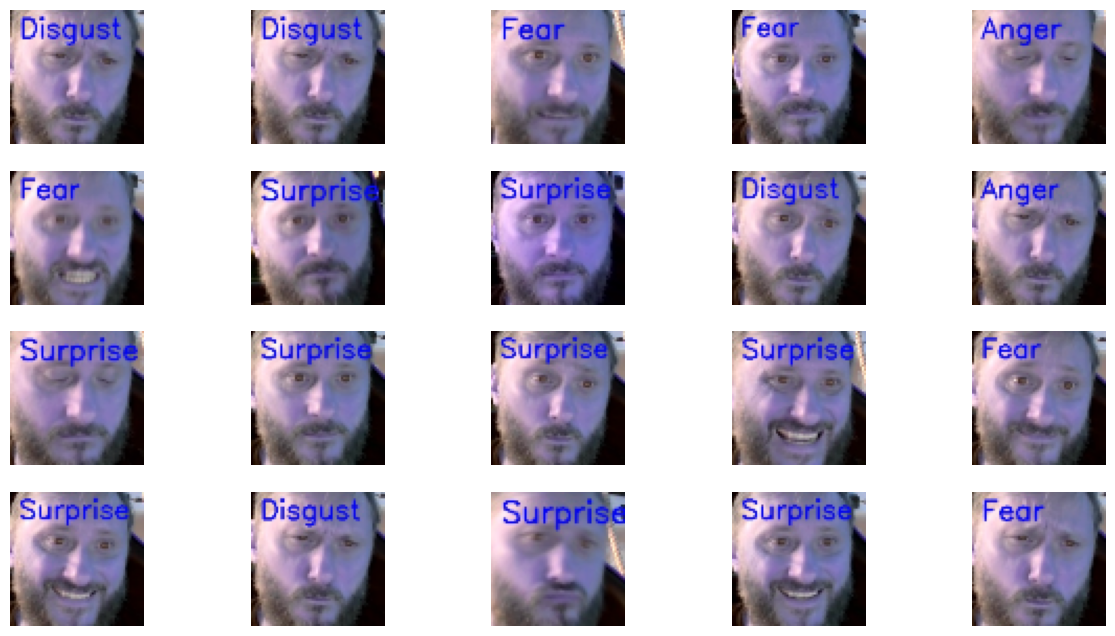

In [41]:
def plot_image_grid(images, ncols=None, cmap='gray', N=20):
    '''Plot a grid of images without emotion labels'''
    # Check if images is empty or has fewer elements than N
    if images.size == 0 or images.shape[0] < N:
        N = images.shape[0] # Adjust N to the number of available images
        if N == 0: # If images is empty, skip the rest of the function
            print("No images to display.")
            return
    
    # Ensure images is a 1-dimensional array of indices
    indices = np.arange(images.shape[0])
    selected_indices = np.random.choice(indices, size=N, replace=False)
    
    if not ncols:
        factors = [i for i in range(1, len(selected_indices)+1) if len(selected_indices) % i == 0]
        ncols = factors[len(factors) // 2] if len(factors) else len(selected_indices) // 4 + 1
    nrows = int(len(selected_indices) / ncols) + int(len(selected_indices) % ncols)
    imgs = [images[i] if len(images) > i else None for i in selected_indices]
    f, axes = pyplot.subplots(nrows, ncols, figsize=(3*ncols, 2*nrows))
    axes = axes.flatten()[:len(imgs)]
    for img, ax in zip(imgs, axes.flatten()): 
        if np.any(img):
            if len(img.shape) > 2 and img.shape[2] == 1:
                img = img.squeeze()
            ax.imshow(img, cmap=cmap)
            ax.axis('off') # Hide axes
    pyplot.show()


plot_image_grid(emotion_images_np, cmap = 'coolwarm')
